# Extracting Ancient Placenames using Named Entity Recognition and `spaCy`

In this notebook, we are going to explore an important subfield of natural language processing, named entity recognition or NER. This notebook was inspired by William Mattingly's textbook on the subject, which you can find here: https://ner.pythonhumanities.com/intro.html. I encourage you to browse this book and play around with the code that he provides.

Objectives:
* Understand what NER is and why it matters
* Collect a training data for a machine learning NER approach
* Train a NER model using `spaCy`'s utilities
* Do some basic inference to see where our model succeeds and where it fails

What is NER and why does it matter?

Named entity recognition describes any method which uses computational methods to extract from unstructured text names of people, places or things. It is a hard classification task, meaning that every word in a document is either a type of named entity or it is not. For example in the following sentences:
> My name is Peter Nadel. I work at Tufts University.

the token 'Peter Nadel' could be tagged as a PERSON tag, where as Tufts Univerisity could be tagged with a PLACE tag. Importantly, in NER, no token can receive more than one tag.

As a result, NER can be using in a wide variety of fields and applications.

In [ ]:
# The example we'll be looking at today comes from these maps that I made
from IPython.display import IFrame

IFrame(
    "https://tuftsgis.maps.arcgis.com/apps/webappviewer/index.html?id=576ff8f0e3954ad781916e94dfb34f7e",
    width=1400,
    height=800,
)

To make a map like the one we see above, I needed to extract place names from an ancient text. Thankfully, ToposText (https://topostext.org/) has marked all of the place names already. So why do we need NER?

ToposText has a lot of texts, but it doesn't have every ancient text. I work quite frequently with faculty members from Classic Studies, examining texts much more obscure than those in ToposText, which may not be digitized at all, let alone have place names marked. So, what we need is an ancient place name NER model, which we can pass any amount of texts and get back all of the places in that text.

*A quick note on `spaCy`'s native English NER*: `spaCy` has NER built into their English and other models. This NER is of good quality for modern texts, but is quite poor when applied to texts that aren't that similar to the training data (in the English model's case: modern news articles scraped from the web). For specialty tasks like the one we will do today, training your own model will always return better results.

# Scraping

Here, I will show how we got our training data and what form it has to be in for training NER models with `spaCy`.

In [ ]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
import requests

In [ ]:
res_html = requests.get(
    "https://topostext.org/work/148"
).text  # The Natural Histories, Plinius Senior

In [ ]:
topos_test = BeautifulSoup(res_html, features="html")

In [ ]:
p_tags = topos_test.find_all("p")[2:]
p_tags[3].a  # first a tag in the third p tag

`spaCy` expects the training data to be in `jsonl` format, meaning that there must be a list where each element is a list that contains the text and a dictionary of the entities that are in the text, with their label (in this case, their HTML class).

In [ ]:
import collections
import string

TRAIN_DATA = []

for i, p in enumerate(p_tags):
    document = []
    p_text = re.sub("(§\s\d\.\d+)|(§\s\d+)", "", p.text)
    document.append(p_text.replace("\xa0\xa0", ""))

    ent_dict = collections.defaultdict(list)
    for a in p.find_all("a"):
        span_list = []
        if a.text.istitle():
            if "href" in a.attrs:
                span_list.append(
                    a.text.translate(str.maketrans("", "", string.punctuation))
                )
                span_list.append(a["href"].split("/")[1])
            else:
                span_list.append(
                    a.text.translate(str.maketrans("", "", string.punctuation))
                )
                span_list.append(a["class"][0])
        if len(span_list) > 0:
            ent_dict["entities"].append(span_list)
    document.append(dict(ent_dict))
    TRAIN_DATA.append(document)

In [ ]:
TRAIN_DATA[0]

Importantly though, you can't just use the text of the entities. It must be the indices of the names within the text. So we can do that below.

## TASK 1
We can't feed our model the raw text of a name. Instead, we need to give it the indices of the name in the original text.

Let's write some code to do that.

In [ ]:
test = TRAIN_DATA[0]
test

In [ ]:
type(test)

In [ ]:
test[0], type(test[0])

In [ ]:
test[0].find("Muses")

In [ ]:
test[1], type(test[1])

In [ ]:
test[1]["entities"]

In [ ]:
test[1]["entities"], type(test[1]["entities"])

In [ ]:
test[1]["entities"][0], type(test[1]["entities"][0])

In [ ]:
test[1]["entities"][0][0], type(test[1]["entities"][0][0])

My Solution

In [ ]:
test[0].find("Muses")

In [ ]:
test[1]["entities"][0][0]

In [ ]:
start = test[0].find(test[1]["entities"][0][0])

### Answer
`TRAIN_DATA` -> `List[String, Dict[List[String, String]]]`

In [ ]:
test[0].find("Muses")

In [ ]:
test[1]["entities"]

In [ ]:
# using find method
test[0].find(test[1]["entities"][0][0])

In [ ]:
# add length of the original string
start = test[0].find(test[1]["entities"][0][0])
end = start + len(test[1]["entities"][0][0])
start, end

In [ ]:
# check
test[0][396:401]  # looks good!

In [ ]:
# turn this into a function we can use for each string
def names2indices(train_data_instance):
    for i, name in enumerate(train_data_instance[1]["entities"]):
        # get indices
        start = train_data_instance[0].find(name[0])
        if start != -1:
            end = start + len(name[0])
        else:
            end = -1
            pass

        # update dict
        train_data_instance[1]["entities"][i].pop(0)  # remove string name
        train_data_instance[1]["entities"][i].insert(0, end)  # add end
        train_data_instance[1]["entities"][i].insert(0, start)  # add start

In [ ]:
# do it to all of them in our training data
for instance in TRAIN_DATA:
    if "entities" in instance[1].keys():
        names2indices(instance)

In [ ]:
TRAIN_DATA[0]

## Completing our training data

Now that we can do this to one ToposText URL we can do it to all the others.

In [ ]:
# can make this into a single function
def create_TRAIN_DATA(url):
    """
    Takes in a ToposText URL and creates spaCy training data.
    """

    # scraping
    res = requests.get(url)
    if res:
        res_html = res.text

        soup = BeautifulSoup(res_html, features="html")
        TRAIN_DATA = []

        p_tags = soup.find_all("p")[1:]
        for i, p in enumerate(p_tags):
            document = []
            p_text = re.sub("(§\s\d\.\d+)|(§\s\d+)", "", p.text)
            document.append(p_text.replace("\xa0\xa0", ""))

            ent_dict = collections.defaultdict(list)
            for a in p.find_all("a"):
                span_list = []
                if a.text.istitle():
                    if "href" in a.attrs:
                        span_list.append(a.text)
                        span_list.append(a["href"].split("/")[1])
                    else:
                        try:
                            span_list.append(a.text)
                            span_list.append(a["class"][0])
                        except:
                            continue
                if len(span_list) > 0:
                    ent_dict["entities"].append(span_list)
            document.append(dict(ent_dict))
            TRAIN_DATA.append(document)

        # reformatting
        for instance in TRAIN_DATA:
            if "entities" in instance[1].keys():
                names2indices(instance)

        return TRAIN_DATA

In [ ]:
create_TRAIN_DATA("https://topostext.org/work/148")

In [ ]:
TRAIN_DATA = []
# Max of 901
for i in tqdm(range(2, 901)):
    train = create_TRAIN_DATA(f"https://topostext.org/work/{i}")
    for item in train:
        TRAIN_DATA.append(item)

In [ ]:
len(TRAIN_DATA)

In [ ]:
TRAIN_DATA[:3]

In [ ]:
# pickling let's us save this work so we don't have to do it again
import pickle

file_name = "topostext_training_data.pkl"

# pickle and save the data
with open(file_name, "wb") as file:
    pickle.dump(TRAIN_DATA, file)

print(f"Training data saved to {file_name}")

# Training
Now that we have our data in the correct form, we can start training.

First, we have to convert the `TRAIN_DATA` object into a special `spaCy` type called a `DocBin` (code taken from Mattingly).

In [ ]:
!wget https://tufts.box.com/shared/static/2p4ez2vas90v2zn8mf3lgdv6lltzl75d.pkl -O topostext_training_data.pkl

In [ ]:
import pickle

with open("/content/topostext_training_data.pkl", "rb") as file:
    loaded_training_data = pickle.load(file)

print("Loaded training data length:", len(loaded_training_data))

In [ ]:
loaded_training_data[0]

The above section in the original Greek.

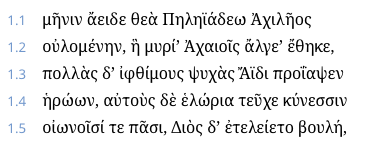

In [ ]:
!mkdir data

In [ ]:
import spacy
from spacy.tokens import DocBin
from pathlib import Path
import warnings


def convert(lang: str, TRAIN_DATA, output_path: Path):
    nlp = spacy.blank(lang)
    nlp.max_length = 2000000
    db = DocBin()
    for text, annot in TRAIN_DATA:
        doc = nlp.make_doc(text)
        ents = []
        if "entities" in annot.keys():
            for start, end, label in annot["entities"]:
                span = doc.char_span(start, end, label=label)
                if span is None:
                    msg = f"Skipping entity [{start}, {end}, {label}] in the following text because the character span '{doc.text[start:end]}' does not align with token boundaries:\n\n{repr(text)}\n"
                    warnings.warn(msg)
                else:
                    ents.append(span)
        try:
            doc.ents = ents
        except:
            continue
        db.add(doc)
    db.to_disk(output_path)

In [ ]:
from sklearn.model_selection import train_test_split

# two splits: first split (train and validation for testing our model after it trains)
train_valid, valid_post_training = train_test_split(
    loaded_training_data, test_size=0.2, random_state=1
)

train, valid = train_test_split(train_valid, test_size=0.2, random_state=1)

In [ ]:
len(train), len(valid), len(valid_post_training)

In [ ]:
import warnings

warnings.filterwarnings("ignore")

convert("en", train, "/content/data/train.spacy")
convert("en", valid, "/content/data/valid.spacy")

In [ ]:
import os

os.listdir("/content/data")

### TASK 2

We still need one final piece before we can start training. This is the config file that will tell the training program how to initialize our set up. We can download a blank version here: https://spacy.io/usage/training.

Finally we just need to add the file locations of our training and validation data. In Colab, double-clicking on the base_config.cfg file will open up an editor on the side. In the train field, put `data/train.spacy` and in the dev field, put `data/valid.spacy`.

In [ ]:
!python -m spacy init fill-config /content/base_config.cfg /content/config.cfg

In [ ]:
# really useful feature in spacy
!python -m spacy debug data /content/config.cfg

In [ ]:
!python -m spacy train config.cfg --output models

In [ ]:
# zip up model for easier download
!zip -r topostext_ner_model_full.zip models

In [ ]:
from google.colab import files

files.download("topostext_ner_model_full.zip")

# Inference

Now that we have a model, we can see how well we did. For this inference step, I want to use example texts that I know were not in the training data.

In [ ]:
!git clone https://github.com/pnadelofficial/topos_text_NER.git

In [ ]:
!unzip topos_text_NER/topostext_ner_model_full.zip

In [ ]:
inf_text = """
An upper vest, once Helen's rich attire,
From Argos by the fam'd adultress brought,
With golden flow'rs and winding foliage wrought,
Her mother Leda's present, when she came
To ruin Troy and set the world on flame;
The scepter Priam's eldest daughter bore,
Her orient necklace, and the crown she wore
Of double texture, glorious to behold,
One order set with gems, and one with gold.
"""

# Vergil Aenid 1.643
# perseus.tufts.edu/hopper/text?doc=Perseus%3Atext%3A1999.02.0052%3Abook%3D1%3Acard%3D643

In [ ]:
import spacy

trained_nlp = spacy.load("models/model-best")

In [ ]:
doc = trained_nlp(inf_text)

In [ ]:
type(doc)

In [ ]:
people = []
for ent in doc.ents:
    if ent.label_ == "people":
        places.append(ent)

In [ ]:
people

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [ ]:
# spacy pretrained model
test_doc = nlp(inf_text)
[(e, e.label_) for e in test_doc.ents]

In [ ]:
# ours
[(e, e.label_) for e in doc.ents]

### Evaluation

In this section, we'll use the `valid_post_training` list of examples to calculate an F1 score for our model. This score is a good summary of how well our model does on this NER task, as it not only counts what entities the model correctly identified, but also considers if their labels are correct as well.

F1 score is the harmonic mean of *precision*, the ratio of correctly identified entities (true positives, TP) and all identified entities (the sum of true positives and false positives, FP), and *recall*, the ratio of correctly identified entities (TP) and all true entities (true positives and false negatives, FN).

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$

In [ ]:
len(valid_post_training)

In [ ]:
valid_post_training[0]

In [ ]:
import spacy

trained_nlp = spacy.load("models/model-best")

In [ ]:
doc = trained_nlp(valid_post_training[0][0])
predicted_ents = [(d.text, d.label_) for d in doc.ents]
predicted_ents

In [ ]:
true_ents_raw = valid_post_training[0][1]["entities"]
true_ents = []
for t_e in true_ents_raw:
    text = valid_post_training[0][0][t_e[0] : t_e[1]]
    true_ents.append((text, t_e[-1]))

true_ents

In [ ]:
predicted_set = set(predicted_ents)
true_set = set(true_ents)

In [ ]:
true_positives = len(predicted_set.intersection(true_set))
false_positives = len(predicted_set - true_set)
false_negatives = len(true_set - predicted_set)

In [ ]:
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

In [ ]:
precision, recall, f1_score

In [ ]:
def eval_one(i):
    doc = trained_nlp(valid_post_training[i][0])
    predicted_ents = [(d.text, d.label_) for d in doc.ents]

    true_ents_raw = valid_post_training[i][1]["entities"]
    true_ents = []
    for t_e in true_ents_raw:
        text = valid_post_training[i][0][t_e[0] : t_e[1]]
        true_ents.append((text, t_e[-1]))

    predicted_set = set(predicted_ents)
    true_set = set(true_ents)

    true_positives = predicted_set.intersection(true_set)
    false_positives = predicted_set - true_set
    false_negatives = true_set - predicted_set

    return len(true_positives), len(false_positives), len(false_negatives)

In [ ]:
from tqdm import tqdm  # for the progress bar

all_true_positives = 0
all_false_positives = 0
all_false_negatives = 0

for i in tqdm(range(len(valid_post_training))):
    if "entities" in valid_post_training[i][1]:
        tp, fp, fn = eval_one(i)
        all_true_positives += tp
        all_false_positives += fp
        all_false_negatives += fn

precision = all_true_positives / (all_true_positives + all_false_positives)
recall = all_true_positives / (all_true_positives + all_false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

In [ ]:
round(f1_score, 3)  # not too shabby!

Yay! We did it!